In [1]:
import tensorflow as tf

physical_device = tf.config.list_physical_devices('GPU')
print('No. of GPU: ', len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

No. of GPU:  1


# Image features extraction

## Importing images as a dataset

In [2]:
ds_img = tf.data.Dataset.list_files("../Data/flickr30k_images/flickr30k_images/*.jpg")

iter(ds_img).get_next()

<tf.Tensor: shape=(), dtype=string, numpy=b'..\\Data\\flickr30k_images\\flickr30k_images\\91875542.jpg'>

In [3]:
# import os
# import glob

# path = "../Data/flickr30k_images/flickr30k_images"
# img_paths = glob.glob(path + '*/*.jpg')

# img_paths[:5]

## Loading pre-trained model for feature extraction

In [4]:
IV3 = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

In [5]:
# IV3.summary()

In [6]:
x = IV3.input
y = IV3.layers[-1].output

feat_model = tf.keras.Model(x, y)

feat_model.trainable = False

In [7]:
# feat_model.summary()

## Make image dataset and apply preprocessing

In [8]:
# import cv2
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def img_preprocess(img):

#     img = cv2.resize(img, (299, 299), interpolation = cv2.INTER_AREA)
#     # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
    
#     return img

# data_gen = ImageDataGenerator(preprocessing_function = img_preprocess)
# # tf.keras.applications.inception_v3.preprocess_input)

# ds_img = data_gen.flow_from_directory(directory = "../Data/flickr30k_images/flickr30k_images/",
#                                       target_size = (299, 299),
#                                       batch_size = 32)

In [9]:
# list(ds_img.as_numpy_iterator())

In [10]:
def img_preprocess(img_path):
    
    img_name = tf.strings.split(img_path, sep = '\\')[-1]
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, expand_animations = False)
    img = tf.image.resize(img, [299, 299])
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return (img_name, img)

In [11]:
# x = img_preprocess(img_paths[:1][0])[1]

# feat_model(x.numpy().reshape(1, 299, 299, 3))

In [12]:
ds_img = ds_img.map(img_preprocess, num_parallel_calls = tf.data.AUTOTUNE)

# iter(ds_img).get_next()

## Extract features from images and save

In [13]:
def img_feature(imgs_name, imgs):
    
    imgs_feat = feat_model(imgs)
    # print(imgs_feat.shape)
    imgs_feat = tf.reshape(imgs_feat, (-1, 8*8, imgs_feat.shape[3]))
        
    return (imgs_name, imgs_feat)

ds_img = ds_img.batch(32)

ds_img_feat = ds_img.map(img_feature, num_parallel_calls = tf.data.AUTOTUNE)
# ds_img_feat = ds_img.map(lambda names, imgs: (names, feat_model(imgs)))

# iter(ds_img_feat).get_next()

In [15]:
%%time

import os
import numpy as np

os.makedirs("../Data/Image_features_files", exist_ok = True)

ds_img_feat = ds_img_feat.unbatch()
for name, feat in ds_img_feat:
    path = os.path.join("../Data/Image_features_files", name.numpy().decode("utf-8"))
    np.save(path, feat)

Wall time: 55min 43s


In [16]:
# save the feature model for later

feat_model.save("../Data/Saved_files/feat_model.h5")

In [17]:
feat_model.save_weights("../Data/Saved_files/feat_model_weights.h5")

In [18]:
# import numpy as np

# os.makedirs("../Data/Image_features", exist_ok = True)

# for paths, imgs in ds_img:
#     imgs_feat = feat_model(imgs)
#     for path, feat in zip(paths, imgs_feat):
#         path = path.numpy().decode("utf-8")
#         path = os.path.join("../Data/Image_features", os.path.basename(path))
#         np.save(path, feat)

In [19]:
# %%time

# # Saving image feature dataset 

# ds_img_feat.save('../Data/Image_features')

In [20]:
# x = tf.data.Dataset.load('../Data/Image_features')

In [21]:
# # Number of batches * 32

# tf.data.Dataset.cardinality(x).numpy()*32

# Captions text preprocessing

In [1]:
import pandas as pd

capt = pd.read_csv('../Data/flickr30k_images/results.csv', delimiter = '|', skipinitialspace = True)

print(capt.shape)
capt.head()

(158915, 3)


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [3]:
# Number of images

capt['image_name'].nunique()

31783

In [4]:
imgs_name = list(capt['image_name'].unique())

In [5]:
capt.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [6]:
capt.loc[1, 'comment']

'Two young , White males are outside near many bushes .'

In [7]:
capt.dtypes

image_name        object
comment_number    object
comment           object
dtype: object

In [8]:
capt['comment'] = capt['comment'].apply(lambda x: '<start> ' + str(x) + ' <end>')

In [9]:
capt.loc[1, 'comment']

'<start> Two young , White males are outside near many bushes . <end>'

In [10]:
# capt.loc[0, 'comment'].split()

In [11]:
# capt['comment'] = capt['comment'].apply(lambda x: x.split())

In [12]:
from tensorflow.keras.preprocessing import text

In [13]:
def capt_to_tokens(sent):
    return text.text_to_word_sequence(sent, filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

capt['comment'] = capt['comment'].apply(lambda x: capt_to_tokens(x))

In [15]:
capt.loc[1, 'comment']

['<start>',
 'two',
 'young',
 'white',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '<end>']

## Train word2vec model on captions text

In [15]:
%%time

from gensim import models

model = models.Word2Vec(capt['comment'], 
                        vector_size = 300, workers = 4, epochs = 35,
                        min_count = 1, sample = 6e-5, 
                        alpha = 0.03, min_alpha = 0.0007, negative = 20)

# max_vocab_size = 100000,

Wall time: 1min 3s


In [16]:
model.wv.index_to_key[:10]

['a', '<start>', '<end>', 'in', 'the', 'on', 'and', 'man', 'is', 'of']

In [17]:
# Load google pre-trained word2vec model:

pre_model = models.keyedvectors.load_word2vec_format(r"../Data/word2vec-google-news-300.bin.gz", binary = True)

In [18]:
# import gensim.downloader as api

# pre_model = api.load('word2vec-google-news-300')
# pre_model_path = api.load('word2vec-google-news-300', return_path = True)

In [19]:
pre_model.index_to_key[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [20]:
# len(model.wv)

model.wv.vectors.shape

(18315, 300)

In [21]:
# len(pre_model)

pre_model.vectors.shape

(3000000, 300)

In [23]:
# Update vocabulary of w2v model with pre-trained model:

model.build_vocab([pre_model.index_to_key], update = True)

In [24]:
model.wv.vectors.shape

(3001373, 300)

In [27]:
model.wv.vectors_lockf

array([1.], dtype=float32)

## Import the pre-trained model's word vectors and then re-train the model

In [28]:
%%time

import numpy as np

model.wv.vectors_lockf = np.ones(len(model.wv))

model.wv.intersect_word2vec_format("../Data/word2vec-google-news-300.bin.gz", binary = True)

model.wv.vectors_lockf = np.ones(1, dtype = np.float32)

# "../Data/word2vec-google-news-300/word2vec-google-news-300.gz"

Wall time: 1min 58s


In [31]:
%%time

model.train(capt['comment'], total_examples = len(capt), epochs = model.epochs)

Wall time: 5min 55s


(56197755, 79627485)

In [32]:
model.wv.vectors.shape

(3001373, 300)

In [33]:
model.save('../Data/Saved_files/w2v_trained.kv')

In [34]:
model.wv.save_word2vec_format('../Data/Saved_files/w2v_trained.bin', binary = True)

In [17]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('../Data/Saved_files/w2v_trained.bin', binary = True)

## Padding, tokenize, sequence and saving embedding matrix

In [18]:
# tokens = list(set([token for row in capt['comment'].values for token in row]))

# len_tokens = len(tokens)

In [19]:
# import numpy as np

# mat = np.zeros((len_tokens, 300))

# for i, token in enumerate(tokens):
#     try:
#         mat[i, :] = model[token]
#     except:
#         pass

In [20]:
# mat.shape

In [21]:
# '0' in tokens

In [22]:
# capt['comment'].apply(lambda x: [tokens.index(token) for token in x])

In [23]:
max_len_comm = max(capt['comment'].apply(lambda x: len(x))) 

def padding(comment):
    
    len_comm = len(comment)
    for i in range(0, max_len_comm - len_comm):
        comment.append('0')
    return comment

capt['comment'] = capt['comment'].apply(padding)

In [ ]:
capt.loc[1, 'comment']

In [25]:
from tensorflow.keras.preprocessing import text

In [26]:
tokenizer = text.Tokenizer(filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(capt['comment'])

In [27]:
print(len(tokenizer.index_word))

18315


In [ ]:
tokenizer.word_index

In [39]:
len_tokens = len(tokenizer.word_index)

import numpy as np

mat = np.zeros((len_tokens+1, 300))

for i, token in enumerate(tokenizer.word_index):
    try:
        mat[i+1, :] = model[token]
    except:
        pass

In [40]:
mat

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36578223, -0.05033149,  0.01246989, ..., -0.05926593,
        -0.09697975,  0.00581587],
       [ 3.83778119, -0.65445286, -3.51577902, ...,  1.98354077,
         3.51716828, -0.56824559],
       ...,
       [-0.25593901, -0.16497333,  0.14506561, ..., -0.06021535,
        -0.18173389,  0.17919731],
       [ 0.22514637,  0.18370514, -0.2780959 , ...,  0.00535598,
         0.07747026, -0.02820838],
       [ 0.18712129,  0.19542101, -0.26880005, ..., -0.2961781 ,
         0.21138805, -0.23856327]])

In [41]:
(pd.DataFrame(mat).sum(axis =1) == 0).sum()

1

In [42]:
tokenizer.word_index['0'] = 0

In [43]:
tokenizer.index_word[0] = '0'

In [ ]:
tokenizer.word_index

In [ ]:
tokenizer.index_word

In [46]:
# mat = np.vstack((np.zeros((1, 300)), mat))

In [51]:
# mat[2,:]

In [52]:
capt['sequence'] = tokenizer.texts_to_sequences(capt['comment'])

In [53]:
capt_seq = capt['sequence'].to_numpy()

In [56]:
# capt['sequence'].iloc[1]

In [57]:
capt.to_csv("../Data/Saved_files/pros_captions.csv", index = None)

np.save("../Data/Saved_files/embeded_mat.npy", mat)

np.save("../Data/Saved_files/caption_sequence.npy", capt_seq)


import json

with open("../Data/Saved_files/word_index.json", 'w') as file:
    json.dump(tokenizer.word_index, file)
    
with open("../Data/Saved_files/index_word.json", 'w') as file:
    json.dump(tokenizer.index_word, file)

---
# Training

## Import libraries and saved files

In [1]:
# pip install scikit-learn

In [2]:
import numpy as np
import json
import pandas as pd

In [3]:
mat = np.load('../Data/Saved_files/embeded_mat.npy')
print(mat.shape)

capt_seq = np.load('../Data/Saved_files/caption_sequence.npy', allow_pickle = True)
print(capt_seq.shape)

word_index = dict()
with open('../Data/Saved_files/word_index.json', 'rb') as file:
    word_index = json.load(file)
    
df = pd.read_csv('../Data/Saved_files/pros_captions.csv')

(18316, 300)
(158915,)


F:\Anaconda\envs\Image_caption\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Split data into train-test with group of same images in the same split

In [33]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import shuffle

gss = GroupShuffleSplit(n_splits = 1, test_size = 0.98, random_state = 0)
split = gss.split(X = df['image_name'], y = capt_seq, groups = df['image_name'])

train_ind, test_ind = next(split)

x_train, y_train = shuffle(df['image_name'][train_ind], capt_seq[train_ind], random_state = 0)
x_test, y_test = shuffle(df['image_name'][test_ind], capt_seq[test_ind], random_state = 0)

In [5]:
%%time

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train.tolist()))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test.tolist()))

Wall time: 38 s


In [6]:
# %%time

# ds_imgs_feat = tf.data.Dataset.load('../Data/Image_features')

In [7]:
import os

def final_ds(name, seq):
    
    feat = np.load(os.path.join("../Data/Image_features_files", name.numpy().decode('utf-8') + ".npy"))
    
    return (feat, seq)

In [8]:
ds_train = ds_train.map(lambda name, seq: tf.py_function(func = final_ds, 
                                                         inp = [name, seq], 
                                                         Tout = [tf.float16, tf.int32]), 
                        num_parallel_calls = tf.data.AUTOTUNE)

ds_test = ds_test.map(lambda name, seq: tf.py_function(func = final_ds, 
                                                         inp = [name, seq], 
                                                         Tout = [tf.float16, tf.int32]), 
                        num_parallel_calls = tf.data.AUTOTUNE)

In [9]:
# create batches in the dataset

batch_size = 64
ds_train = ds_train.batch(batch_size, drop_remainder = True)
ds_test = ds_test.batch(batch_size, drop_remainder = True)

In [10]:
# m = iter(ds_train).get_next()

## Defining Encoder, Attention and Decoder classes

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, embeded_dim):
        super().__init__()
        self.dense = tf.keras.layers.Dense(embeded_dim, activation = 'relu')
        
    def call(self, x):
        
        x = self.dense(x)
        
        return x

In [12]:
# i = iter(ds_train).get_next()

# x = i[0]
# y = i[1]

# print(x.shape, y.shape)

# x = encoder.call(x)
# print(x.shape)

In [13]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.weig_1 = tf.keras.layers.Dense(units, activation = 'relu')
        self.weig_2 = tf.keras.layers.Dense(units, activation = 'relu')
        self.vec = tf.keras.layers.Dense(1)
        
    def call(self, feat, hidden):
        
        hidden = tf.expand_dims(hidden, axis = 1)
        
        score = tf.nn.tanh(self.weig_1(feat) + self.weig_2(hidden))

        atten_weig = tf.nn.softmax(self.vec(score), axis = 1)
        
        context = atten_weig*feat
        context = tf.reduce_sum(context, axis = 1)

        return context, atten_weig

In [14]:
# attention = Attention(units)

# hidd_state = tf.zeros([batch_size, units])

# print(hidd_state.shape)

# context, atten_weig = attention.call(x, hidd_state)

# print(context.shape, atten_weig.shape)

In [15]:
from tensorflow. keras.initializers import constant

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, units, embeded_mat, len_sent):
        super().__init__()
        self.units = units
        self.embeded_mat = tf.keras.layers.Embedding(input_length = len_sent,
                                                     input_dim = embeded_mat.shape[0], 
                                                     output_dim = embeded_mat.shape[1],
                                                     embeddings_initializer = constant(embeded_mat), trainable = False)
        self.lstm = tf.keras.layers.LSTM(units, return_sequences = True, return_state = True)
        self.dense_1 = tf.keras.layers.Dense(units, activation = 'relu')
        self.dense_2 = tf.keras.layers.Dense(embeded_mat.shape[0])
        
        self.attention = Attention(units)
        
    def call(self, feat, hidd_state, token):
        
        context, atten_weig = self.attention.call(feat, hidd_state)
        
        y  = self.embeded_mat(token)
        
        context = tf.expand_dims(context, axis = 1)
        y = tf.concat([context, y], axis = 2)

        output, hidd_state, seq = self.lstm(y)
        
        y = self.dense_1(output)
        
        y = tf.reshape(y, [-1, y.shape[2]])

        y = self.dense_2(y)
        
        return y, hidd_state, atten_weig

In [17]:
embeded_dim = 300
units = 512
len_sent = len(x_train[315])

encoder = Encoder(embeded_dim)
decoder = Decoder(units, mat, len_sent)

In [18]:
# token = tf.expand_dims([word_index['0']] * y.shape[0], axis = 1)

# print(token.shape)

# y, hidd_state, atten_weig = decoder.call(x, hidd_state, token)

# print(y.shape, hidd_state.shape, atten_weig.shape)

In [19]:
# len(decoder.trainable_variables)

## Defining loss function and training loop

In [20]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_func(target, pred):
    
    # mask = [0 if i == 0 else 1 for i in target]
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    
    loss = loss_obj(target, pred)
    
    mask = tf.cast(mask, dtype = loss.dtype)
    
    loss = mask * loss
    
    return tf.reduce_mean(loss)

In [ ]:
# boundaries = [4866, 36495, 48660, 60825]
# values = [5e-3, 1e-3, 8e-4, 5e-4, 1e-4]

boundaries = [12165]
values = [8e-5, 5e-5]

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [22]:
batch_size

64

In [27]:
@tf.function
def training(img_feat, target_capt):
    
    token = tf.expand_dims([word_index['<start>']] * target_capt.shape[0], axis = 1)
    hidd_state = tf.zeros([batch_size, units])
    # print('******', hidd_state.shape)
    
    batch_loss = 0
    with tf.GradientTape() as tape:
        
        feat = encoder(img_feat)
        
        for i in range(1, target_capt.shape[1]):
            
            # print('inp:', feat.shape, hidd_state.shape, token.shape)
            pred, hidd_state, atten_weig = decoder(feat, hidd_state, token)
            # print('out:', feat.shape, hidd_state.shape, token.shape)
            token = tf.expand_dims(target_capt[:, i], axis = 1)
            
            batch_loss = batch_loss + loss_func(target_capt[:, i], pred)
        
        tot_loss = batch_loss/target_capt.shape[1]
        
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(batch_loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return batch_loss, tot_loss

In [28]:
checkpoint_path = "../Data/Checkpoints/train"
checkpoint = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)

checkpoint_mangr = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep = 6)

resume_epoch = 0
if checkpoint_mangr.latest_checkpoint:
    resume_epoch = int(checkpoint_mangr.latest_checkpoint.split('-')[-1])
    checkpoint.restore(checkpoint_mangr.latest_checkpoint)

resume_epoch

0

In [29]:
loss_plot = []

try:
    with open("../Data/loss.txt", 'r') as f:
        loss_plot = list(map(lambda x: float(x), f.readlines()))
except:
    pass

In [ ]:
epochs = 1
n_steps = len(ds_train)

for epoch in range(resume_epoch, epochs):
    
    total_loss = 0
    for (batch_num, (img_feat, target_capt)) in enumerate(ds_train):
        
        batch_loss, tot_loss = training(img_feat, target_capt)
        total_loss = total_loss + tot_loss
        
        if batch_num%25 == 0:
            print("epoch: {} --> batch: {} --> loss: {}".format(epoch+1, batch_num, batch_loss.numpy()/target_capt.shape[1]))
            
    loss_plot.append(total_loss/n_steps)
    with open("../Data/loss.txt", 'a') as f:
        f.write(str(total_loss/n_steps))
        f.write('\n')    
    
    checkpoint_mangr.save()
    print("epoch: {} --> batch: {}".format(epoch+1, total_loss/n_steps))

In [ ]:
encoder.save_weights("../Data/Model_weights/Encoder/encoder")
decoder.save_weights("../Data/Model_weights/Decoder/decoder")

---
# Evaluation

## Import libraries and saved files

In [2]:
import numpy as np
import json
import pandas as pd

In [3]:
mat = np.load('../Data/Saved_files/embeded_mat.npy')
print('mat: ', mat.shape)

capt_seq = np.load('../Data/Saved_files/caption_sequence.npy', allow_pickle = True)
print('capt_seq: ', capt_seq.shape)

word_index = dict()
with open('../Data/Saved_files/word_index.json', 'rb') as file:
    word_index = json.load(file)
    
df = pd.read_csv('../Data/Saved_files/pros_captions.csv')

mat:  (18316, 300)
capt_seq:  (158915,)


F:\Anaconda\envs\Image_caption\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
index_word = {j : i for i, j in word_index.items()}
# index_word

## Load Encoder, Attention and Decoder

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self, embeded_dim):
        super().__init__()
        self.dense = tf.keras.layers.Dense(embeded_dim, activation = 'relu')
        
    def call(self, x):
        
        x = self.dense(x)
        
        return x

In [6]:
class Attention():
    def __init__(self, units):
        super().__init__()
        self.weig_1 = tf.keras.layers.Dense(units, activation = 'relu')
        self.weig_2 = tf.keras.layers.Dense(units, activation = 'relu')
        self.vec = tf.keras.layers.Dense(1)
        
    def call(self, feat, hidden):
        
        hidden = tf.expand_dims(hidden, axis = 1)
        score = tf.nn.tanh(self.weig_1(feat) + self.weig_2(hidden))
    
        atten_weig = tf.nn.softmax(self.vec(score), axis = 1) 
        
        context = atten_weig*feat
        context = tf.reduce_sum(context, axis = 1)
        
        return context, atten_weig

In [7]:
from tensorflow.keras.initializers import constant

In [8]:
class Decoder(tf.keras.Model):
    def __init__(self, units, embeded_mat, len_sent):
        super().__init__()
        self.units = units
        self.embeded_mat = tf.keras.layers.Embedding(input_length = len_sent,
                                                     input_dim = embeded_mat.shape[0], 
                                                     output_dim = embeded_mat.shape[1],
                                                     embeddings_initializer = constant(embeded_mat), trainable = False)
        self.lstm = tf.keras.layers.LSTM(units, return_sequences = True, return_state = True)
        self.dense_1 = tf.keras.layers.Dense(units, activation = 'relu')
        self.dense_2 = tf.keras.layers.Dense(embeded_mat.shape[0])
        
        self.attention = Attention(units)
        
    def call(self, feat, hidd_state, token):
        
        context, atten_weig = self.attention.call(feat, hidd_state)
        
        y  = self.embeded_mat(token)
        
        context = tf.expand_dims(context, axis = 1)
        y = tf.concat([context, y], axis = 2)
        
        output, hidd_state, seq = self.lstm(y)
        
        y = self.dense_1(output)
        y = tf.reshape(y, [-1, y.shape[2]])
        y = self.dense_2(y)
        
        return y, hidd_state, atten_weig

In [9]:
embeded_dim = 300
units = 512
len_sent = 80

encoder = Encoder(embeded_dim)
decoder = Decoder(units, mat, len_sent)

In [10]:
encoder.load_weights("../Data/Kaggle_notebook/Training/Model_weights/Encoder/encoder")
decoder.load_weights("../Data/Kaggle_notebook/Training/Model_weights/Decoder/decoder")

## Evaluate new image

In [11]:
def img_preprocess(img_path):
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, expand_animations = False)
    img = tf.image.resize(img, [299, 299])
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    # img = tf.expand_dims(img, 0)
    
    return img

In [12]:
# IV3 = tf.keras.applications.InceptionV3()
# x = IV3.input
# y = IV3.layers[-3].output

feat_model = tf.keras.models.load_model("../Data/Saved_files/feat_model.h5")

In [13]:
def evaluation(img_path):
    
    img = img_preprocess(img_path)
    img = tf.expand_dims(img, axis = 0)
    img_feat = feat_model(img)
    img_feat = tf.reshape(img_feat, (-1, 8*8, img_feat.shape[3]))
    
    feat = encoder(img_feat)
    hidd_state = tf.zeros([1, units])
    decoder_inp = tf.expand_dims([word_index['<start>']], axis = 0)
    
    attention_plot = np.zeros((len_sent, 64))
    result = []
    for i in range(len_sent):
        
        pred, hidd_state, atten_weig = decoder(feat, hidd_state, decoder_inp)
        
        attention_plot[i] = tf.reshape(atten_weig, (-1, )).numpy()
        pred_id = tf.random.categorical(pred, 1)[0][0].numpy()
        # pred_id = np.argmax(pred)
        
        result.append(index_word[pred_id])
  
        if index_word[pred_id] == '<end>':
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot
    
        # pred_id = np.random.choice(np.argsort(pred)[0][-3:-1])
        decoder_inp = tf.expand_dims([pred_id], axis = 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [167]:
x_test.iloc[3000]

'2560278143.jpg'

In [168]:
# Test image:

image_folder = "../Data/flickr30k_images/flickr30k_images/"
img_name = "2560278143.jpg"

img_path = image_folder + img_name

img_path

'../Data/flickr30k_images/flickr30k_images/2560278143.jpg'

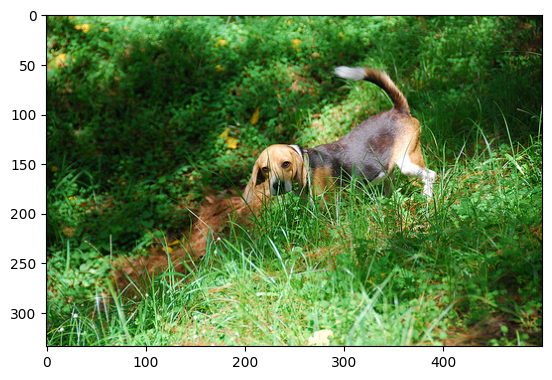

In [169]:
import matplotlib.pyplot as plt

img = plt.imread(img_path)
plt.imshow(img)

In [170]:
result, attention_plot = evaluation(img_path)

x = True
while x:
    if 3 < len(result) < 25:
        x = False
    else:
        result, attention_plot = evaluation(img_path)

In [171]:
# result, attention_plot = evaluation(img_path)

In [172]:
result = " ".join(result)

print(result)

basset but is a very white dog wants carefully crosses dog walks or dog runs dog walks down area <end>


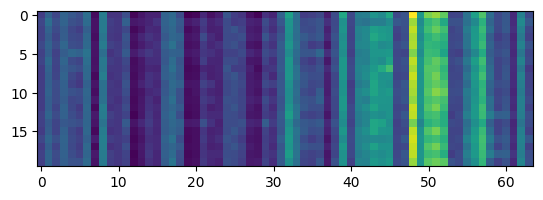

In [173]:
plt.imshow(attention_plot)

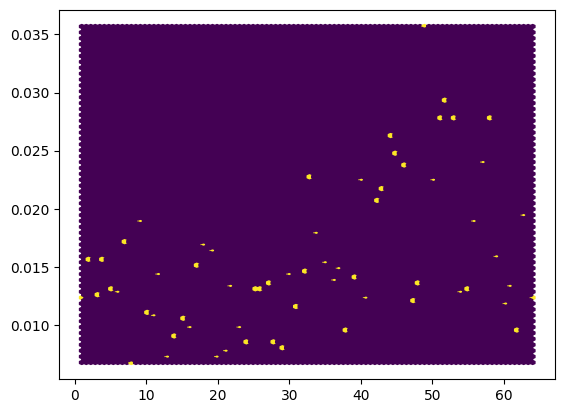

In [174]:
plt.hexbin(np.arange(1, 65), attention_plot[3])

In [175]:
def plot_attention(img_path, result, attention_plot):
    temp_image = plt.imread(img_path)

    fig = plt.figure(figsize=(10, 10), dpi=200)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> basset hound on a grassy slope <end>
Prediction Caption: a beagle stands playing dog jumps dog follows for someone with being tied dog jumping dog walks down area <end>


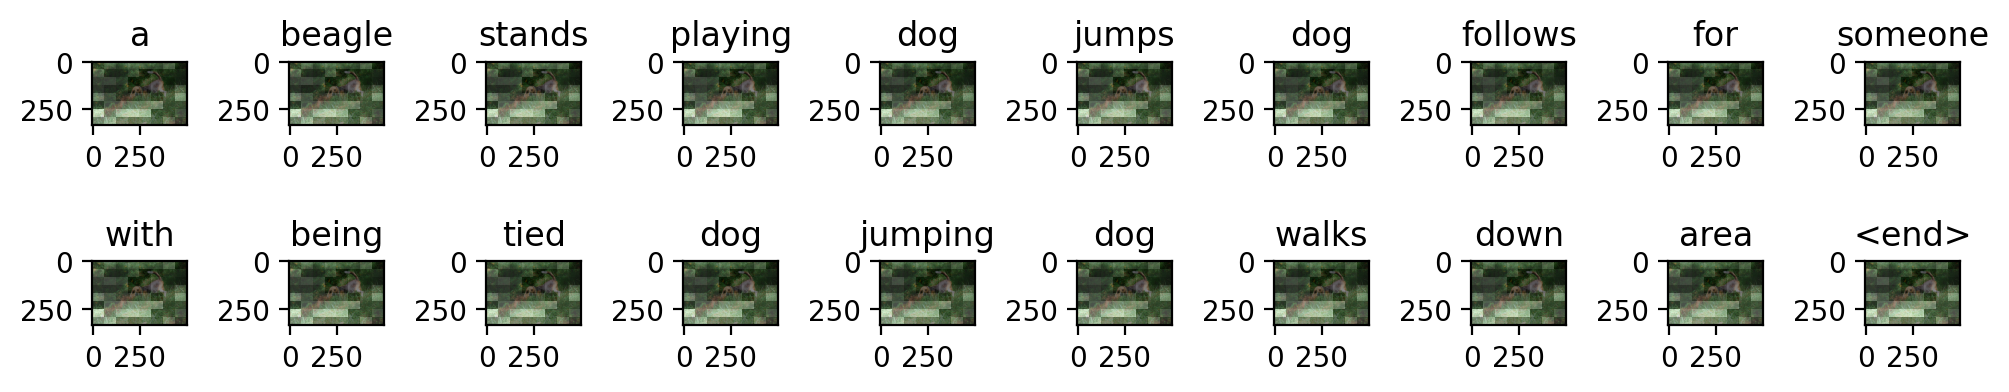

In [176]:
real_caption = ' '.join(index_word[i] for i in y_test[3000] if i != 0)
result, attention_plot = evaluation(img_path)

bl = True 
while(bl): #sanity check (avoiding predictions having > 20 words)
    if(len(result)<=25):
        bl =False
    else:
        # print(len(result))
        result, attention_plot = evaluation(img_path)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_path, result, attention_plot)

In [165]:
# loss plot:

import re

list_loss = []
with open("../Data/Kaggle_notebook/Training/loss.txt", 'r') as file:
    for line in file.readlines():
        list_loss.append(float(re.split("[\(,]", line)[1]))

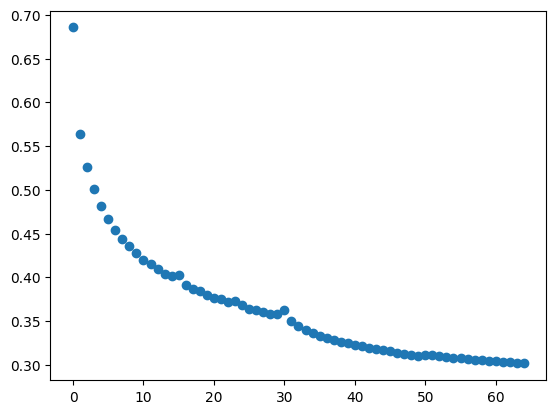

In [166]:
plt.scatter(np.arange(len(list_loss)), list_loss)